# Определение стоимости автомобилей
# Описание проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

# Описание данных
Данные находятся в файле `/datasets/autos.csv`

**Признаки:**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак:**
* Price — цена (евро)

# План работы

**1. Загрузка данных**

Загрузите данные и выполните их первичный осмотр.

**2. Исследовательский анализ и предобработка данных**

Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.

**3. Подготовка выборок для обучения моделей**

Разделить данные на три выборки для обучения, валидации и теста моделей.

**4. Обучение моделей машинного обучения**

Обучить разные модели на основе бустинга, а также модель не бустинг

**5. Анализ времени обучения, времени предсказания и качествв моделей**

Для каждой модели замерить время обучения и предсказания, а также провести оценку качества модели при помощи RMSE.

**6. Выбор лучшей модели**

На основе полученных данных составить таблицу времени и точности моделец. Наилучшую модель протестировать на тестовых данных.

**7. Общий вывод и рекомендации заказчику**

Сделайте общий вывод о проделанной работе: опишите основные этапы работы, полученные результаты и дайте рекомендации для бизнеса.


## Подготовка данных

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import phik
import sklearn

# Предобработка данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Модели обучение
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Метрики
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


RANDOM_STATE = 3

In [2]:
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [3]:
display(df.sample(5))
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
351601,2016-03-25 20:38:21,13333,bus,2011,auto,160,altea,60000,8,petrol,seat,no,2016-03-25,0,57439,2016-04-07 02:45:56
194236,2016-03-10 20:46:42,15999,suv,2010,manual,163,kuga,60000,12,gasoline,ford,no,2016-03-10,0,68649,2016-04-06 07:46:49
120154,2016-03-27 13:58:57,6450,sedan,2007,manual,116,golf,150000,5,petrol,volkswagen,no,2016-03-27,0,49779,2016-03-27 13:58:57
237579,2016-03-12 20:39:32,2300,small,1999,manual,101,a2,150000,1,petrol,audi,NaN,2016-03-12,0,48231,2016-03-20 00:44:45
46672,2016-03-30 08:52:18,490,small,1997,manual,54,corsa,150000,11,petrol,opel,no,2016-03-30,0,29439,2016-03-30 09:39:10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [4]:
round(df.isna().mean()*100, 2)

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
Repaired             20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

**Вывод** Типы данных при выгрузке соответсвуют своим значениям. Имеются пропуски в данных в некоторых из столбцов. Больше всего пропусков в столбце Repaired состовляющий 20% от общего количества данных. Пропуск в данных вероятно связан с человеческим фактором

### Предобработка данных

In [5]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

4
0


In [6]:
data_new = df.copy()
display(data_new.describe(include='object'))
data_new.describe()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
count,316875,334532,334660,321470,354365,283211
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268249,29232,216349,77012,247158


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
data_new.fillna({'Gearbox':'manual','Repaired':'no','Model':'unknown'}, inplace=True)
data_new.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.000000
Power                0.000000
Model                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
Repaired             0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

**Вывод** `Gearbox`, `Repaired` заменил на моду. Пропуски в `Model` заполнил значением `unknown`

In [8]:
data_new['VehicleType'] = (data_new.groupby(['Brand', 'Model'])['VehicleType'].transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "unknown"))))
data_new['FuelType'] = (data_new.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "unknown"))))
data_new.isnull().sum()
data_new.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

**Вывод** Пропуски в `VehicleType` и `FuelType` заполнил данными из столбцов  `Brand` и `Model`

In [9]:
data_new.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
# Мощность и цена должны быть выше нуля
data_new = data_new[data_new['Price'] != 0]
data_new = data_new[data_new['Power'] != 0]

In [11]:
# Дата авто должна быть выше 1930 года,и ниже 2025
print(np.sort(data_new.RegistrationYear.unique()))
data_new = data_new.query('1930 < RegistrationYear < 2017')
data_new.RegistrationYear.describe()

[1000 1234 1400 1500 1600 1800 1910 1923 1927 1928 1929 1930 1931 1932
 1933 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2800 2900 3000 4000 4500 4800 5000 5911 6000 6500 8000 8200 9999]


count    296878.000000
mean       2002.818565
std           6.529658
min        1931.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

count    296878.000000
mean        124.290449
std         190.818205
min           1.000000
25%          75.000000
50%         111.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64


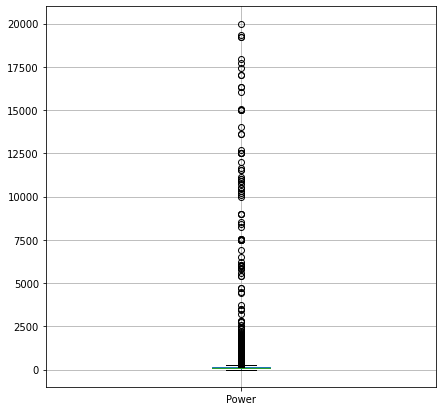

In [12]:
print(data_new.Power.describe())

data_new.Power.plot(kind='box', grid= True, figsize=(7,7))
plt.show()

In [13]:
# уберу значения выше 500 л.с. и ниже 50 л.с.

data_new = data_new.query('50 < Power < 500')
data_new['Power'].describe()

count    286660.000000
mean        123.056855
std          52.360980
min          51.000000
25%          82.000000
50%         115.000000
75%         150.000000
max         490.000000
Name: Power, dtype: float64

Оставлю только те колонки которые необхадимы модели. Колонки PostalCode, LastSeen, RegistrationMonth , DateCrawled для задачи не требуются. 

In [14]:
data_new = data_new[['VehicleType','Gearbox', 'Power','Kilometer','FuelType','Brand','Repaired','RegistrationYear','Model','Price']]
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286660 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       286660 non-null  object
 1   Gearbox           286660 non-null  object
 2   Power             286660 non-null  int64 
 3   Kilometer         286660 non-null  int64 
 4   FuelType          286660 non-null  object
 5   Brand             286660 non-null  object
 6   Repaired          286660 non-null  object
 7   RegistrationYear  286660 non-null  int64 
 8   Model             286660 non-null  object
 9   Price             286660 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.1+ MB


In [15]:
data_new.phik_matrix(
    interval_cols=data_new.select_dtypes(include='number').columns.tolist())

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model,Price
VehicleType,1.000000,0.283668,0.478658,0.181488,0.325594,0.633790,0.060327,0.174462,0.915526,0.255042
Gearbox,0.283668,1.000000,0.587395,0.026517,0.146983,0.498919,0.026964,0.109502,0.615988,0.328293
Power,0.478658,0.587395,1.000000,0.104266,0.252209,0.563675,0.059756,0.217270,0.767263,0.506123
Kilometer,0.181488,0.026517,0.104266,1.000000,0.142458,0.270202,0.090104,0.384854,0.446358,0.319903
FuelType,0.325594,0.146983,0.252209,0.142458,1.000000,0.288732,0.030086,0.240749,0.535851,0.253389
Brand,0.633790,0.498919,0.563675,0.270202,0.288732,1.000000,0.082206,0.342013,0.997698,0.360256
Repaired,0.060327,0.026964,0.059756,0.090104,0.030086,0.082206,1.000000,0.146400,0.127003,0.302537
RegistrationYear,0.174462,0.109502,0.217270,0.384854,0.240749,0.342013,0.146400,1.000000,0.567386,0.637083
Model,0.915526,0.615988,0.767263,0.446358,0.535851,0.997698,0.127003,0.567386,1.000000,0.568518
Price,0.255042,0.328293,0.506123,0.319903,0.253389,0.360256,0.302537,0.637083,0.568518,1.000000


In [16]:
print(data_new.FuelType.unique())
data_new.FuelType.replace('gasoline', 'petrol', inplace=True)
print(data_new.FuelType.unique())

['gasoline' 'petrol' 'lpg' 'other' 'hybrid' 'cng' 'electric']
['petrol' 'lpg' 'other' 'hybrid' 'cng' 'electric']


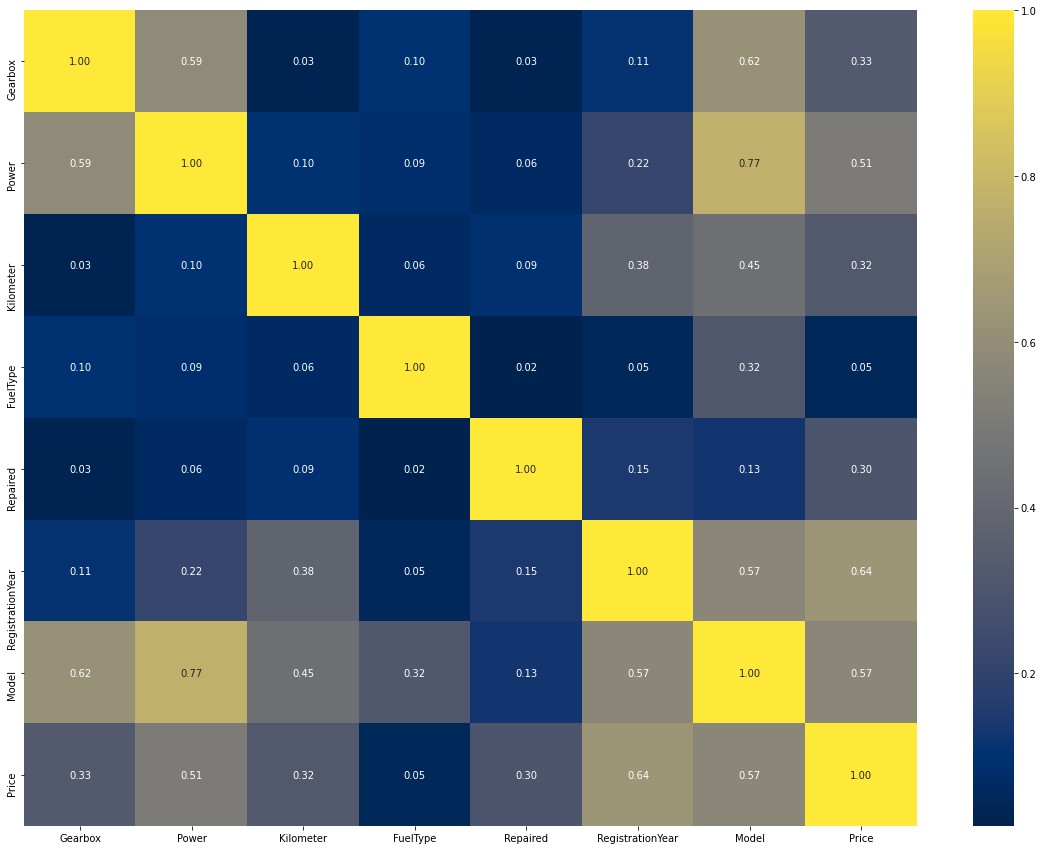

In [17]:
# Избавлюст от мультиколлинеарности убрав столбец `VehicleType`
plt.figure(figsize=(20,15))
sns.heatmap(data_new.drop(['VehicleType', 'Brand'], 1).phik_matrix(
    interval_cols=data_new.select_dtypes(include='number').columns.tolist()),
            annot=True, fmt='.2f', cmap='cividis')
plt.show()

**Вывод** 

* В ходе предобработки данных были заполнены пропуски в данных
* Присутствовали аномальные значения в небольшом колличестве и убраны
* Исправлены альтернативные названия бензины на единый `petrol`
* Для устранения мультиколлинеарности в итоговой таблице были вытеснены два столбца `VehicleType` и `Brand`

### Подготовка данных для модели

In [18]:
X = data_new.drop('Price', 1)
y = data_new['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=RANDOM_STATE)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(214995, 9)
(71665, 9)
(214995,)
(71665,)


In [20]:
# категориальные признаки для OHE 
cat_col_names = X_train.select_dtypes(include='object').columns.to_list()
print(cat_col_names)
num_col_names = X_train.select_dtypes(exclude='object').columns.to_list()
print(num_col_names)

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']
['Power', 'Kilometer', 'RegistrationYear']


In [21]:
# encoder, scaler
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# DataFrame
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], 1)
X_test = pd.concat([X_test_ohe, X_test_scaled], 1)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [22]:
print(X_train.shape)
display(X_train.sample(3))
print(X_test.shape)
display(X_test.sample(3))

(214995, 303)


,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_hybrid,...,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Power,Kilometer,RegistrationYear
78777,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380528,0.588733,-0.643730
105006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.268630,0.588733,1.109611
149999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.163337,-1.050742,1.428400


(71665, 303)


,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_hybrid,...,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Power,Kilometer,RegistrationYear
68392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.345002,0.588733,1.269005
19442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.421373,0.588733,-0.643730
58940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.345002,0.588733,1.109611


**Вывод** Данные для обучения модели были разделены в соотношении 3:1. Было проведено кодирование категориальных данных, а также проведено масштабированние численных данных.

## Обучение моделей
Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

Проанализируйте время обучения, время предсказания и качество моделей.

### LinearRegression

In [23]:
model_lr = LinearRegression()

In [24]:
# Время обучения

start = time()

model_lr.fit(X_train, y_train)

end = time()

fit_time_lr = round(end - start, 2)
print(fit_time_lr, 'sec')

19.74 sec


In [25]:
# Время предсказания

start = time()
rmse_lr = cross_val_score(model_lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=2)
end = time()

rmse_lr = round(abs(rmse_lr).mean())
print('rmse =', rmse_lr)

pred_time_lr = round(end - start, 2)
print(pred_time_lr, 'sec')

rmse = 2662
19.51 sec


### LightGBM

In [40]:
lgbm_r = LGBMRegressor(random_state=RANDOM_STATE)

parameters = {
    "max_depth": [20, 80],
    "learning_rate" : [0.1, 0.15],
    "n_estimators": [80, 150]
}

gs_lgbm_r = GridSearchCV(
    lgbm_r,
    parameters,
    cv=2,
    scoring='neg_root_mean_squared_error'
)

# Возьмём лучшие парраметры и время сколько уходит на подбор

start = time()

gs_lgbm_r.fit(X_train, y_train)

end = time()

bst_prm_lgbm = round(end - start, 2)
print(bst_prm_lgbm, 'sec')

148.32 sec


In [ ]:
lgbm_r = gs_lgbm_r

In [53]:
lgbm_r_params = gs_lgbm_r.best_params_
lgbm_r_params

# с гиперпараметрами
lgbm_r = LGBMRegressor(max_depth = lgbm_r_params['max_depth'],
                             learning_rate = lgbm_r_params['learning_rate'],
                             n_estimators = lgbm_r_params['n_estimators'], 
                             random_state = RANDOM_STATE)

# Время обучения

start = time()

lgbm_r.fit(X_train, y_train)

end = time()

fit_time_lgbm_r = round(end - start, 2)
print(fit_time_lgbm_r, 'sec')

10.55 sec


In [54]:
# Время предсказания

start = time()
rmse_lgbm_r = cross_val_score(lgbm_r, X_train, y_train, scoring='neg_root_mean_squared_error', cv=2)
end = time()

rmse_lgbm_r = round(abs(rmse_lgbm_r).mean())
print('rmse =', rmse_lgbm_r)

pred_time_lgbm_r = round(end - start, 2)
print(pred_time_lgbm_r, 'sec')

rmse = 1659
38.32 sec


### CatBoost

In [66]:
cb_r = CatBoostRegressor(random_state=RANDOM_STATE)

parameters = {
    "max_depth": [8, 13],
    "learning_rate" : [0.1, 0.15],
    "n_estimators": [80, 150]
}

gs_cb_r = GridSearchCV(
    cb_r,
    parameters,
    cv=2,
    scoring='neg_root_mean_squared_error'
)

# Возьмём лучшие парраметры и время сколько уходит на подбор

start = time()

gs_cb_r.fit(X_train, y_train)

end = time()

bst_prm_cb_r = round(end - start, 2)
print(bst_prm_cb_r, 'sec')

0:	learn: 4308.7595883	total: 28.6ms	remaining: 2.26s
1:	learn: 4025.5854740	total: 51.1ms	remaining: 1.99s
2:	learn: 3777.3628627	total: 71.3ms	remaining: 1.83s
3:	learn: 3560.5234175	total: 90.8ms	remaining: 1.72s
4:	learn: 3368.4646490	total: 111ms	remaining: 1.66s
5:	learn: 3205.6537194	total: 130ms	remaining: 1.61s
6:	learn: 3054.2959611	total: 150ms	remaining: 1.56s
7:	learn: 2926.3578692	total: 169ms	remaining: 1.52s
8:	learn: 2811.0019041	total: 188ms	remaining: 1.48s
9:	learn: 2707.4527060	total: 207ms	remaining: 1.45s
10:	learn: 2621.9254656	total: 227ms	remaining: 1.42s
11:	learn: 2544.9273289	total: 247ms	remaining: 1.4s
12:	learn: 2476.0085894	total: 265ms	remaining: 1.37s
13:	learn: 2418.9182762	total: 284ms	remaining: 1.34s
14:	learn: 2366.0038368	total: 303ms	remaining: 1.31s
15:	learn: 2316.8138782	total: 324ms	remaining: 1.29s
16:	learn: 2273.0054866	total: 343ms	remaining: 1.27s
17:	learn: 2236.4545079	total: 370ms	remaining: 1.27s
18:	learn: 2201.0465651	total: 391m

In [70]:
gs_cb_r_params = gs_cb_r.best_params_

In [71]:
# с гиперпараметрами
cb_r = CatBoostRegressor(max_depth = gs_cb_r_params['max_depth'],
                             learning_rate = gs_cb_r_params['learning_rate'],
                             n_estimators = gs_cb_r_params['n_estimators'], 
                             random_state = RANDOM_STATE)

# Время обучения

start = time()

cb_r.fit(X_train, y_train)

end = time()

fit_time_cb_r = round(end - start, 2)
print(fit_time_cb_r, 'sec')

0:	learn: 4123.8024561	total: 207ms	remaining: 30.8s
1:	learn: 3699.1661998	total: 372ms	remaining: 27.5s
2:	learn: 3348.2405629	total: 522ms	remaining: 25.6s
3:	learn: 3056.8380359	total: 669ms	remaining: 24.4s
4:	learn: 2814.7690347	total: 812ms	remaining: 23.6s
5:	learn: 2615.5988954	total: 957ms	remaining: 23s
6:	learn: 2456.8738909	total: 1.1s	remaining: 22.5s
7:	learn: 2335.0516518	total: 1.25s	remaining: 22.1s
8:	learn: 2229.1354994	total: 1.39s	remaining: 21.8s
9:	learn: 2146.2656530	total: 1.54s	remaining: 21.6s
10:	learn: 2071.2776561	total: 1.69s	remaining: 21.4s
11:	learn: 2017.4259314	total: 1.84s	remaining: 21.2s
12:	learn: 1974.6975468	total: 2.01s	remaining: 21.2s
13:	learn: 1936.1333389	total: 2.16s	remaining: 21s
14:	learn: 1901.4652955	total: 2.31s	remaining: 20.8s
15:	learn: 1878.1212815	total: 2.45s	remaining: 20.5s
16:	learn: 1856.9632045	total: 2.6s	remaining: 20.3s
17:	learn: 1838.8922361	total: 2.75s	remaining: 20.1s
18:	learn: 1824.4200965	total: 2.91s	remaini

In [72]:
# Время предсказания

start = time()
rmse_cb_r = cross_val_score(cb_r, X_train, y_train, scoring='neg_root_mean_squared_error', cv=2)
end = time()

rmse_cb_r = round(abs(rmse_cb_r).mean())
print('rmse =', rmse_cb_r)

pred_time_cb_r = round(end - start, 2)
print(pred_time_cb_r, 'sec')

0:	learn: 4117.9686266	total: 136ms	remaining: 20.3s
1:	learn: 3700.6655030	total: 258ms	remaining: 19.1s
2:	learn: 3351.1605286	total: 376ms	remaining: 18.4s
3:	learn: 3070.7662805	total: 493ms	remaining: 18s
4:	learn: 2836.6812045	total: 613ms	remaining: 17.8s
5:	learn: 2641.1835288	total: 746ms	remaining: 17.9s
6:	learn: 2483.1545762	total: 865ms	remaining: 17.7s
7:	learn: 2351.1189273	total: 982ms	remaining: 17.4s
8:	learn: 2243.8697880	total: 1.1s	remaining: 17.3s
9:	learn: 2160.1683615	total: 1.23s	remaining: 17.2s
10:	learn: 2091.8290640	total: 1.35s	remaining: 17.1s
11:	learn: 2034.3038850	total: 1.48s	remaining: 17s
12:	learn: 1989.1656360	total: 1.61s	remaining: 17s
13:	learn: 1946.8862872	total: 1.75s	remaining: 17s
14:	learn: 1913.8678025	total: 1.88s	remaining: 16.9s
15:	learn: 1889.5537135	total: 2.02s	remaining: 16.9s
16:	learn: 1865.4028819	total: 2.16s	remaining: 16.9s
17:	learn: 1842.5152415	total: 2.28s	remaining: 16.7s
18:	learn: 1827.3795232	total: 2.42s	remaining:

**Вывод** Проведено обучение трех моделей LinearRegression, LightGBM, CatBoost. Было расчитано время обучения, время предсказания и качество моделей.

## Анализ моделей

Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

In [76]:
columns = ['Модель', 'Время обучения, сек', 'Время предсказания, сек', 'RMSE']
regression_model = ['LinearRegression', fit_time_lr, pred_time_lr, rmse_lr]
LightGBM_model = ['LightGBM', fit_time_lgbm_r, pred_time_lgbm_r, rmse_lgbm_r]
CatBoost_model = ['CatBoost', fit_time_cb_r, pred_time_cb_r, rmse_cb_r]

table = pd.DataFrame([regression_model, LightGBM_model, CatBoost_model], columns = columns)

table

,Модель,"Время обучения, сек","Время предсказания, сек",RMSE
0,LinearRegression,19.74,19.51,2662
1,LightGBM,10.55,38.32,1659
2,CatBoost,25.01,40.77,1626


In [77]:
best_predictions = lgbm_r.predict(X_test)
best_rmse = round(root_mean_squared_error(y_test, best_predictions))
print(f'RMSE LightGBM = {best_rmse}')

RMSE LightGBM = 1637


## Заключение

**Предобработка и анализ данных**

Было выявлено:
* Все данные соответствуют свои значениям
* Наибольшие пропуски в признаке `Repaired` около 20%, связаны с человеческим фактором. Машина не ремонтировалась, так что данная строка не была заполнена некоторыми пользователями
* Убраны лишние признаки `PostalCode, LastSeen, RegistrationMonth , DateCrawled`, не нужны для определения стоимости авто
* Для устранения мультиколлинеарности в итоговой таблице были вытеснены два столбца `VehicleType и Brand`

**Обучение и тестирование моделей**

Во время Обучение модели было выявлено:

* В качестве обучающих моделей использовались LinearRegression, LightGBM, CatBoostRegressor
* Наилучшей оказалась модель CatBoostRegressor, точность модели состовляет RMSE=1626

Во время тестирования модели было выявлено:

* Значение RMSE на тестовых данных составила 1637, что удовлетворяет условию заказчика и ниже значения 2500